Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math

In [3]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [4]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from bc import *
import pickle

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    final_control = us[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state, final_control)


In [6]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

In [7]:

def lane(posx):
    ts = [90, 100, 150]
    rate = 8.0
    height = 10.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/(1 * rate)), np.arctan(-height * np.exp((posx - ts[0])/(1 * rate)/(1 * rate)))
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0])  + (posx - ts[0])/10.0, 1.0/10.0
    elif posx > ts[1]:
        return -height * np.exp((ts[1] - posx)/(1 * rate)) + (ts[1] - ts[0])/10.0, np.arctan(+ height * np.exp((ts[1] - posx)/(1 * rate)))

'''

def nominal(posx):
    ts = [80, 90, 150]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/(1 * rate)), np.arctan(-height * np.exp((posx - ts[0])/(1 * rate)/(1 * rate)))
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return -height * np.exp((ts[1] - posx)/(1 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(1 * rate)))


def lane(posx):
    ts = [30, 60, 90, 120]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/rate), np.arctan(-height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[3]:
        return -height * np.exp((ts[1] - posx)/(2 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(2 * rate)))
    #elif posx > ts[2] and posx <= ts[3]:
    #    return -height * np.exp((posx - ts[2])/rate), np.arctan(-height * np.exp((posx - ts[2])/rate)/rate)
    elif posx > ts[3]:
        return -height * np.exp((posx - ts[3])/(2 * rate)), np.arctan(+ height * np.exp((ts[3] - posx)/(2 * rate)))
    
def nominal(posx):
    ts = [30, 60, 90, 120]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/rate), np.arctan(-height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[3]:
        return -height * np.exp((ts[1] - posx)/(2 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(2 * rate)))
    #elif posx > ts[2] and posx <= ts[3]:
    #    return -height * np.exp((posx - ts[2])/rate), np.arctan(-height * np.exp((posx - ts[2])/rate)/rate)
    elif posx > ts[3]:
        return -height * np.exp((posx - ts[3])/(2 * rate)), np.arctan(+ height * np.exp((posx - ts[3])/(2 * rate)))
'''

def barrier_u(posx):
    ts = [80, 90, 150]
    if posx <= ts[0]:
        return + 1 + posx, + 3 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[0] and posx <= ts[1]:
        return + 1 + posx, + 3 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[1]:
        return + 1 + posx, + 3 + lane(posx)[0], lane(posx)[1]
                                                                      
def barrier_l(posx):
    ts = [80, 90, 150]
    if posx <= ts[0]:
        return - 1 + posx, -3 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[0] and posx <= ts[1]:
        return - 1 + posx, -3 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[1]:
        return - 1 + posx, -3 + lane(posx)[0], lane(posx)[1]
    
def nominal(posx):
    return barrier_u(posx)[1] * 0.5 + barrier_l(posx)[1] * 0.5, (barrier_u(posx)[2] + barrier_l(posx)[2]) * 0.5

  

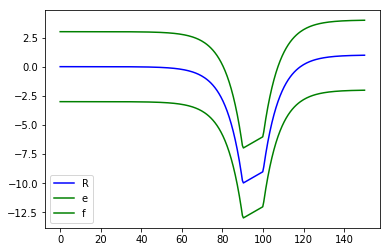

In [8]:
posx_path = np.linspace(0, 150, 300)
x_nominal = [[posx_path[i], nominal(posx_path[i])[0], 10, nominal(posx_path[i])[1]] for i in range(300)]
x_barrier_u = [[posx_path[i], barrier_u(posx_path[i])[1], 10, barrier_u(posx_path[i])[1]] for i in range(300)]
x_barrier_l = [[posx_path[i], barrier_l(posx_path[i])[1], 10, barrier_l(posx_path[i])[1]] for i in range(300)]
x_lane = [[posx_path[i], lane(posx_path[i])[0], 10, nominal(posx_path[i])[1]] for i in range(300)]

posx_ = np.asarray(x_nominal)[:, 0]
posy_ = np.asarray(x_lane)[:, 1]
posy_u = np.asarray(x_barrier_u)[:, 1]
posy_l = np.asarray(x_barrier_l)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_u, 'g')
_ = plt.plot(posx_, posy_l, 'g')
_ = plt.legend("Reference Path")


In [9]:
n = 2
agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H2', batch_size = 100, checkpoint = 'checkpoints/mlp_H2.pt')

#agent.data_process(paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p'])
#agent.train(num_epoch = 1000)


In [10]:
def agent_run(agent, x0s):
    agent_traj = []
    for x0 in x0s:
        agent_traj.append([])
        for _ in range(0, N):
            i = abs(int(x0[0]/0.5))
            x_nn = []
            if i >= N - H - 1:
                break
            x_nominal_ = x_nominal[i: i + H]
            for j in [x0] + x_nominal_[:]:
                for k in j:
                    x_nn.append(k)
            u = agent.run([x_nn])
            agent_traj[-1] = agent_traj[-1] + [[x0[:], u[0]]]
            x1 = dynamics.f(x0, u[0], i)[0]        
            x0 = x1[:]
    return agent_traj

x0s = []
batch_size = 20
for i_batch in range(batch_size):
    x0s.append([x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)])  # Initial state.
    
N = 300
H = 2
agent_traj = agent_run(agent, x0s)
        

print("Done")

/home/depend/virtualenv_py3/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/depend/virtualenv_py3/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Done


The red curve in the plot shows the trajectory of the regression model controller.

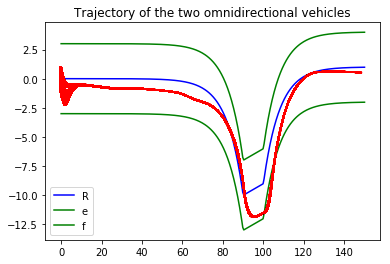

In [11]:
def draw_agent_traj(agent_trajs):
    plt.title("Trajectory of the two omnidirectional vehicles")
    plt.legend(["Vehicle", "Reference Path"])
    
    posx_ = np.asarray(x_nominal)[:, 0]
    posy_ = np.asarray(x_lane)[:, 1]
    posy_u = np.asarray(x_barrier_u)[:, 1]
    posy_l = np.asarray(x_barrier_l)[:, 1]
    _ = plt.plot(posx_, posy_, "b")
    _ = plt.plot(posx_, posy_u, 'g')
    _ = plt.plot(posx_, posy_l, 'g')
    _ = plt.legend("Reference Path")

    posx = []
    posy = []
    v = []
    theta = []
    for agent_traj in agent_trajs:
        posx.append([])
        posy.append([])
        v.append([])
        theta.append([])
        for j in agent_traj:
            posx[-1].append(j[0][0])
            posy[-1].append(j[0][1])
            v[-1].append(j[0][2])
            theta[-1].append(j[0][3])
            plt.plot(posx[-1], posy[-1], "r")

    plt.show()

draw_agent_traj(agent_traj)

In [12]:
N = len(x_nominal)
H = 2  # Number of time steps in trajectory.
n = 20
n_init = 0
#n_end = 250
n_end = N - H - 1

# Initial state.
x0s = [[x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
              x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
              x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
              x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)] for i in range(1)]

# Random initial action path.
us_init = np.zeros((n - 1, dynamics.action_size))

J_hist = []

# Instantenous state cost.
Q = 0.0 * np.eye(dynamics.state_size)
Q[3, 3] = 0.0
Q[1, 1] = 0.0

R = np.eye(dynamics.action_size)
R[0, 0] = 0.0
R[1, 1] = 0.0


q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1., 0, 0]], [[0, -1., 0, 0]]])
b = np.array([[-0.0], [0.0]])
q1 = [150.0, 10.0]
q2 = [150.0, 10.0]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])

def MPSC(agent, x0s):
    train_traj = []
    nn_traj = []
    mpc_traj= []
    traj = []
    for num in range(len(x0s)):
        train_traj.append([])
        nn_traj.append([])
        mpc_traj.append([])
        traj.append([])
        x0 = x0s[num]
        for step in range(n_init, n_end):
            print(">>>>>Step {} at {}".format(step, x0))
            i = abs(int(x0[0]/0.5))
            if i > n_end:
                break
            x_nominal_ = x_nominal[i: i + H]
            x_nn = []
            for j in [x0] + x_nominal_[:]:
                for k in j:
                    x_nn.append(k)
            u = agent.run([x_nn])
            #print("NN outputs control")
            agent_traj[-1] = agent_traj[-1] + [[x0, u[0, :]]]
            x1 = dynamics.f(x0, u[0], i)[0]
            #print("Get next state")

            if i <= n_end - n - 1:
                n_ilqr =  n 
            elif n_end > i:
                n_ilqr = n_end - i
            else:
                break

            x0_ = x1[:]
            us_ = []
            xs_ = []
            for _ in range(n_ilqr):
                i_ = abs(int(x0_[0]/0.5))
                x_nn_ = []
                for j in [x0_] + x_nominal[i_ : i_ + H]:
                    for k in j:
                        x_nn_.append(k)
                while len(x_nn_) < 4 *(H + 1):
                    for k in x_nominal[-1]:
                        x_nn_.append(k)
                u_ = agent.run([x_nn_])
                xs_.append(x0_[:])
                us_.append(u_[0])
                x1_ = dynamics.f(x0_, u_[0], i_)[0][:]
                x0_ = x1_[:]
            xs_ = np.asarray(xs_)
            us_init = np.asarray(us_[:-1])
            
            if (np.squeeze(\
                (xs_ - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs_])).dot(A[0].T) - b[0,0]\
                           <= 0)).all() == True and \
                (np.squeeze(\
                (xs_ - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs_])).dot(A[1].T) - b[1,0]\
                          <= 0)).all() == True:
                traj[-1].append([x0, u[0, :]])
                nn_traj[-1].append(traj[-1][-1])
                #train_traj[-1].append([x_nn, u[0, :]])
                print("Utilize NN output {}".format(u))
            else: 
                x_nominal_ilqr = x_nominal[i + 1: i + 1 + n_ilqr]
                #us_init = np.random.uniform(-1, 1, (n_ilqr - 1, dynamics.action_size))


                cost_ = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:], \
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                ilqr_ = iLQR(dynamics, cost_, n_ilqr - 1)
                try:
                    xs, us = ilqr_.fit(x1, us_init, on_iteration=on_iteration)
                except TypeError as e:
                    print(e)
                    return traj, nn_traj, mpc_traj, train_traj
                us = np.exp(-np.logaddexp(0, -us))
                #print("MPC verifying")


                if (np.squeeze(\
                    (xs - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).all() == True and \
                    (np.squeeze(\
                    (xs - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                              <= 0)).all() == True:
                    traj[-1].append([x0, u[0, :]])
                    nn_traj[-1].append(traj[-1][-1])
                    train_traj[-1].append([x_nn, u[0, :]])
                    print("Utilize NN output {}".format(u))
                else:
                    max_itr = 50
                    while (np.squeeze(\
                    (xs - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).all() == False or \
                    (np.squeeze(\
                    (xs - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                              <= 0)).all() == False :

                        if max_itr == 0:
                            return  traj, nn_traj, mpc_traj, train_traj
                        max_itr -= 1    
                        cost = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:],\
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                        ilqr = iLQR(dynamics, cost, n_ilqr - 1)
                        xs, us = ilqr.fit(x0, us_init, n_iterations = (51 - max_itr) * 100, on_iteration=on_iteration)
                        us_init = us[:] + 2 * np.random.random((n - 1, dynamics.action_size)) - 1.0
                        us_init = np.zeros((n - 1, dynamics.action_size))

                        us = np.exp(-np.logaddexp(0, -us))
                    traj[-1].append([x0, us[0]])
                    mpc_traj[-1].append(traj[-1][-1])
                    train_traj[-1].append([x_nn, us[0]])
                    x1 = dynamics.f(x0, us[0], i)[0]
                    print("Utilize MPC output {}".format(us[0]))
                    
            x0 = x1[:]
            
        return  traj, nn_traj, mpc_traj, train_traj
    
traj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)


>>>>>Step 0 at [0.39900493665079617, 0.8320303449982533, 10.396455344535626, -1.0767088538284288]
Utilize NN output [[0.02265126 0.46101525]]
>>>>>Step 1 at [ 0.64553311  0.37435251 10.39758771 -0.85271134]
Utilize NN output [[0.03181099 0.3950743 ]]
>>>>>Step 2 at [ 0.98761065 -0.01718148 10.39917773 -0.65737889]
Utilize NN output [[0.02279078 0.3284439 ]]
>>>>>Step 3 at [ 1.39923087 -0.33491669 10.40031707 -0.49248856]
Utilize NN output [[0.02737881 0.2886639 ]]
>>>>>Step 4 at [ 1.85747764 -0.58080685 10.40168567 -0.34641371]
Utilize NN output [[0.03052856 0.24335702]]
>>>>>Step 5 at [ 2.34670293 -0.75740233 10.40321162 -0.22228828]
Utilize NN output [[0.03208489 0.1948451 ]]
>>>>>Step 6 at [ 2.85410434 -0.8720869  10.40481532 -0.12220094]
Utilize NN output [[0.03240889 0.1468592 ]]
>>>>>Step 7 at [ 3.37050573 -0.93550763 10.40643519 -0.04634337]
Utilize NN output [[0.03198482 0.103175  ]]
>>>>>Step 8 at [ 3.89030877e+00 -9.59614319e-01  1.04080339e+01  7.15114535e-03]
Utilize NN out

Utilize NN output [[ 0.0707077  -0.00265378]]
>>>>>Step 71 at [ 3.68631615e+01 -8.26282252e-01  1.05660948e+01 -6.69962550e-03]
Utilize NN output [[ 0.0685192  -0.00223712]]
>>>>>Step 72 at [ 3.73915399e+01 -8.29822242e-01  1.05695154e+01 -7.88150202e-03]
Utilize NN output [[ 0.06640898 -0.00185741]]
>>>>>Step 73 at [ 3.79200821e+01 -8.33988035e-01  1.05728310e+01 -8.86309459e-03]
Utilize NN output [[ 0.06437302 -0.00152472]]
>>>>>Step 74 at [ 3.84487832e+01 -8.38674086e-01  1.05760452e+01 -9.66912584e-03]
Utilize NN output [[ 0.06240778 -0.00124145]]
>>>>>Step 75 at [ 3.89776387e+01 -8.43787816e-01  1.05791616e+01 -1.03256083e-02]
Utilize NN output [[ 0.0605099  -0.00100333]]
>>>>>Step 76 at [ 3.95066441e+01 -8.49250312e-01  1.05821834e+01 -1.08563288e-02]
Utilize NN output [[ 0.1232446  -0.00386991]]
>>>>>Step 77 at [ 4.00358754e+01 -8.54996047e-01  1.05883146e+01 -1.29039229e-02]
Utilize NN output [[ 0.11835171 -0.00257313]]
>>>>>Step 78 at [ 4.05653943e+01 -8.61829297e-01  1.059420

Utilize NN output [[ 0.02244844 -0.01628575]]
>>>>>Step 146 at [77.02261808 -2.69681402 10.84527867 -0.15016466]
Utilize NN output [[ 0.04471538 -0.0537997 ]]
>>>>>Step 147 at [77.55883485 -2.77794557 10.84751295 -0.17931018]
Utilize NN output [[ 0.04070022 -0.04473736]]
>>>>>Step 148 at [78.0925646  -2.8746878  10.84954684 -0.20355846]
Utilize NN output [[ 0.03727386 -0.03765105]]
>>>>>Step 149 at [78.62388725 -2.98436204 10.85140967 -0.22397366]
Utilize NN output [[ 0.03432317 -0.03249482]]
>>>>>Step 150 at [79.15294754 -3.1048796  10.85312516 -0.24159818]
Utilize NN output [[ 0.03175546 -0.02912345]]
>>>>>Step 151 at [79.67988187 -3.23472216 10.8547124  -0.25739774]
Utilize NN output [[ 0.02949825 -0.02733799]]
>>>>>Step 152 at [80.20477309 -3.37289297 10.85618688 -0.27223134]
Utilize NN output [[ 0.02749557 -0.02691445]]
>>>>>Step 153 at [80.72762567 -3.51885348 10.85756131 -0.28683723]
Utilize NN output [[ 0.0257066  -0.02763489]]
>>>>>Step 154 at [81.24835444 -3.67245368 10.85884

/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/ilqr/controller.py:161: UserWarning: Singular matrix
  warnings.warn(str(e))
/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/ilqr/controller.py:168: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


iteration 0 accepted [3.41260842e+08] [ 94.99519924 -13.32410603  10.5398032    3.5628891 ] [ 1.3155143e+04 -6.1101465e+00]
iteration 0 accepted [-2841.57545959] [ 95.8538444  -11.42918808  11.13773638   4.58552296] [ 1.1366245e+04 -8.2897062e+00]
Utilize MPC output [0. 1.]
>>>>>Step 181 at [ 93.14083372 -11.61886782  10.88773638   0.10814407]
iteration 0 accepted [1078096.80543846] [ 96.01333938 -12.65812278  10.63962542   3.84035438] [ 1.1281481e+04 -6.4463801e+00]
iteration 0 accepted [231679.64420932] [ 95.55095806 -12.55333725  10.73773638   3.89135464] [ 8.1761602e+03 -6.4196467e+00]
iteration 0 accepted [-2843.00091168] [ 96.09967031 -10.63874072  10.87811571   4.92596025] [ 5.43642509e+04 -9.84451087e+00]
Utilize MPC output [1.50172179e-05 1.00000000e+00]
>>>>>Step 182 at [ 93.68204032 -11.5601103   10.88773714   0.52274589]
iteration 0 accepted [13094301.41428354] [ 95.25694929 -12.96310279  11.03936615   3.01143985] [ 1.1580219e+04 -4.8485212e+00]
iteration 0 accepted [-2848.

Utilize NN output [[ 0.00865204 -0.04732127]]
>>>>>Step 225 at [113.79093342  -1.47859853  11.0304052    0.33476449]
Utilize NN output [[ 0.00824926 -0.04414647]]
>>>>>Step 226 at [114.31184726  -1.29739496  11.03081765   0.31043261]
Utilize NN output [[ 0.00780939 -0.04087819]]
>>>>>Step 227 at [114.83703462  -1.12891246  11.03120811   0.28789917]
Utilize NN output [[ 0.00734886 -0.0376382 ]]
>>>>>Step 228 at [115.36590298  -0.97230062  11.03157555   0.26714923]
Utilize NN output [[ 0.00688016 -0.03449809]]
>>>>>Step 229 at [115.89792411  -0.826691    11.03191955   0.24812836]
Utilize NN output [[ 0.00641403 -0.03152277]]
>>>>>Step 230 at [116.43263455  -0.69122254  11.03224025   0.23074628]
Utilize NN output [[ 0.00595829 -0.0287532 ]]
>>>>>Step 231 at [116.96963389  -0.56506491  11.03253816   0.21489004]
Utilize NN output [[ 0.00551844 -0.02621399]]
>>>>>Step 232 at [117.50858003  -0.44743452  11.03281408   0.20043301]
Utilize NN output [[ 0.01133533 -0.02108885]]
>>>>>Step 233 at [

289


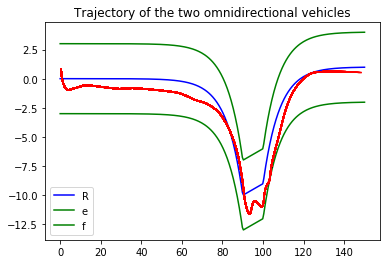

In [13]:
print(len(traj[0]))

draw_agent_traj(traj)
#pickle.dump((traj, nn_traj, mpc_traj, train_traj), open('safe_path_bk1.p', 'wb'))

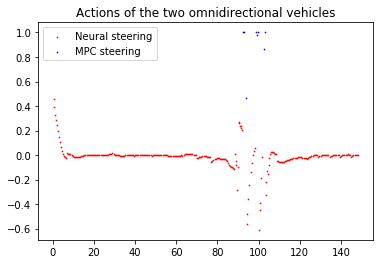

In [14]:
def draw_str(nn_traj, mpc_traj):
    str_nn = []
    posx_nn = []
    str_mpc = []
    posx_mpc = []
    for i in nn_traj[-1]:
        posx_nn.append(i[0][0])
        str_nn.append(i[1][1])
    for j in mpc_traj[-1]:
        posx_mpc.append(j[0][0])
        str_mpc.append(j[1][1])  

    _ = plt.title("Actions of the two omnidirectional vehicles")
    _ = plt.scatter(posx_nn, str_nn, s = 0.5, c = "r")
    _ = plt.scatter(posx_mpc, str_mpc, s = 0.5, c = "b")
    _ = plt.legend(["Neural steering", "MPC steering"])

draw_str(nn_traj, mpc_traj)

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

In [48]:
def data_to_train(data_trajs):
    train_trajs = []
    for i_traj in range(len(data_trajs)):
        train_trajs.append([])
        for i_xy in range(len(data_trajs[i_traj])):
            train_trajs[i_traj].append([])
            x = data_trajs[i_traj][i_xy][0]
            i = abs(int(x[0]/0.5))
            x_nn = []
            for j in [x] + x_nominal[i : i + H]:
                for k in j:
                    x_nn.append(k)
            while len(x_nn) < 4 *(H + 1):
                for k in x_nominal[-1]:
                    x_nn.append(k)
            u = data_trajs[i_traj][i_xy][1][:]
            train_trajs[i_traj][i_xy] = [x_nn[:], u[:]] 
    return train_trajs

def train_pipeline(agent, x0s, train_trajs = None, paths = None, num_epoch = 100):

    
    #agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H2', batch_size = 1, checkpoint = 'checkpoints/mlp_H2_995.pt')
    
    X = []
    Y = []
    
    if train_trajs is not None and train_trajs is not []:
        print(len(train_trajs))
        for i_traj in range(len(train_trajs)):
            for i_xy in range(len(train_trajs[i_traj])):
                X.append([x for x in train_trajs[i_traj][i_xy][0]])
                Y.append([y for y in train_trajs[i_traj][i_xy][1]])
    if train_traj is not None or paths is not None:
        agent.data_process(X = X, Y = Y, paths = paths)
        
    n = int(np.asarray(X[0]).shape[0]/dynamics.state_size) - 1
    agent.train(num_epoch = num_epoch)
    #for i in range(len(X)):
    #    print(agent_.run([X[i]]), Y[i])

    agent_temp_traj = agent_run(agent, x0s)    
    draw_agent_traj(agent_temp_traj)
    
    # Random initial action path.
    us_init = np.zeros((n - 1, dynamics.action_size))

    J_hist = []
    q1 = [100.0, 10.0]
    q2 = [100.0, 10.0]

    trajs_, nn_trajs_, mpc_trajs_, train_trajs_ = MPSC(agent, x0s)
    draw_agent_traj(trajs_)
    draw_str(nn_trajs_, mpc_trajs_)
    return trajs_, nn_trajs_, mpc_trajs_, train_trajs_ 



342
2700
[Epoch 1] avg_loss: 0.168
[Epoch 51] avg_loss: 0.164
Finished Training


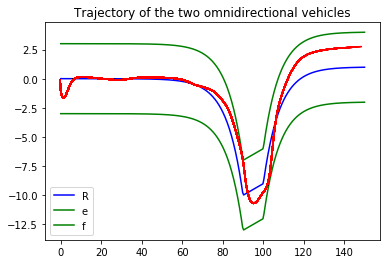

>>>>>Step 0 at [-0.2999364899086613, -0.17488259691580477, 9.74754677570714, -1.3859109565659438]
Utilize NN output [[0.37376744 0.9216605 ]]
>>>>>Step 1 at [-0.21025793 -0.65439272  9.76541091 -1.03174262]
Utilize NN output [[0.3275028 0.8387737]]
>>>>>Step 2 at [ 0.04058605 -1.07376325  9.78122466 -0.69719966]
Utilize NN output [[0.24948436 0.71184427]]
>>>>>Step 3 at [ 0.41575577 -1.38797261  9.79344636 -0.39797634]
Utilize NN output [[0.17156287 0.5992794 ]]
>>>>>Step 4 at [ 0.86735458 -1.5778292   9.80194132 -0.13524921]
Utilize NN output [[0.18747018 0.476635  ]]
>>>>>Step 5 at [ 1.35320548 -1.64394378  9.81120654  0.08213072]
Utilize NN output [[0.2018266  0.36800015]]
>>>>>Step 6 at [ 1.84236029 -1.60367856  9.82116305  0.2549263 ]
Utilize NN output [[0.21444888 0.23841892]]
>>>>>Step 7 at [ 2.31780386 -1.47977984  9.83172409  0.36983479]
Utilize NN output [[0.22228087 0.11956477]]
>>>>>Step 8 at [ 2.77640736 -1.3019916   9.84265864  0.42833269]
Utilize NN output [[0.2268792  0

Utilize NN output [[ 0.19460107 -0.00137632]]
>>>>>Step 111 at [ 5.51681192e+01  4.59532560e-02  1.06571536e+01 -1.84169231e-02]
Utilize NN output [[ 0.186001  -0.0016207]]
>>>>>Step 112 at [ 5.57011163e+01  3.61359788e-02  1.06663479e+01 -1.92805253e-02]
Utilize NN output [[ 0.17796727 -0.0022374 ]]
>>>>>Step 113 at [ 5.62345547e+01  2.58497322e-02  1.06751535e+01 -2.04737667e-02]
Utilize NN output [[ 0.17027156 -0.00270476]]
>>>>>Step 114 at [ 5.67684112e+01  1.49181499e-02  1.06835857e+01 -2.19174471e-02]
Utilize NN output [[ 0.16007823 -0.00483771]]
>>>>>Step 115 at [ 5.73026606e+01  3.20689273e-03  1.06915220e+01 -2.45016294e-02]
Utilize NN output [[ 0.14959046 -0.0067947 ]]
>>>>>Step 116 at [ 5.78372618e+01 -9.89432944e-03  1.06989462e+01 -2.81338567e-02]
Utilize NN output [[ 0.13978006 -0.00794355]]
>>>>>Step 117 at [ 5.83721709e+01 -2.49473584e-02  1.07058900e+01 -3.23831456e-02]
Utilize NN output [[ 0.13063794 -0.00848603]]
>>>>>Step 118 at [ 5.89073471e+01 -4.22841059e-02  1.

Utilize NN output [[ 0.05342444 -0.11160727]]
>>>>>Step 215 at [106.08679902  -3.69219033  11.14469139   0.821735  ]
Utilize NN output [[ 0.06329941 -0.10068095]]
>>>>>Step 216 at [106.46630263  -3.28405378  11.14785214   0.76582089]
Utilize NN output [[ 0.03376213 -0.139505  ]]
>>>>>Step 217 at [106.86810922  -2.89767959  11.14953961   0.68856238]
Utilize NN output [[ 0.03715768 -0.11224481]]
>>>>>Step 218 at [107.29860667  -2.54341374  11.15139664   0.62624995]
Utilize NN output [[ 0.03943266 -0.09002934]]
>>>>>Step 219 at [107.75040703  -2.21658734  11.15336725   0.57618749]
Utilize NN output [[ 0.04076866 -0.07231574]]
>>>>>Step 220 at [108.21808026  -1.91272461  11.15540456   0.53592945]
Utilize NN output [[ 0.04135944 -0.05857819]]
>>>>>Step 221 at [108.6976924   -1.62787822  11.15747135   0.5032936 ]
Utilize NN output [[ 0.04137708 -0.0482721 ]]
>>>>>Step 222 at [109.18643424  -1.35878342  11.15953902   0.47638477]
Utilize NN output [[ 0.04095789 -0.04084444]]
>>>>>Step 223 at [

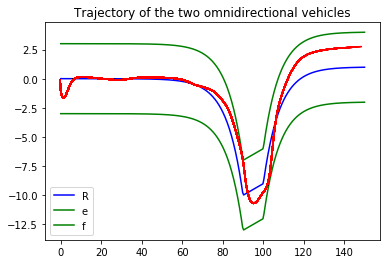

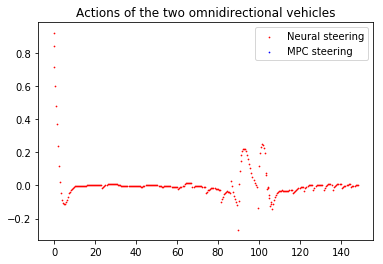

In [579]:
H = 2 
agent_ = NeuralNetwork(input_size = (H + 1) * dynamics.state_size, model_name = 'mlp_temp_H2_temp', batch_size = 500, checkpoint = 'checkpoints/mlp_H2.pt')
paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p']

train_traj_aggr = 100 * train_traj

trajs_, nn_trajs_, mpc_trajs_, train_trajs_  = train_pipeline(agent_, x0s[:itr_train], train_traj_aggr, paths = None)





#raise TypeError
itr_train = 2
batch_size = 3
'''

'''

while itr_train < batch_size:
    # Initial state.
    agent_ = NeuralNetwork(input_size = (H + 1) * dynamics.state_size, model_name = 'mlp_temp_H2', batch_size = 500, checkpoint = 'checkpoints/mlp_temp_H2.pt')
    train_traj_aggr = train_traj_aggr + int((batch_size - itr_train) * 120 + 1) * train_traj_[:]
    trajs_, nn_trajs_, mpc_trajs_, train_trajs_  = train_pipeline(agent_, x0s[:itr_train], train_traj_aggr, paths = None) 
    itr_train += 1
    
    x0s = [[x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
                  x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
                  x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
                  x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)]]

Done


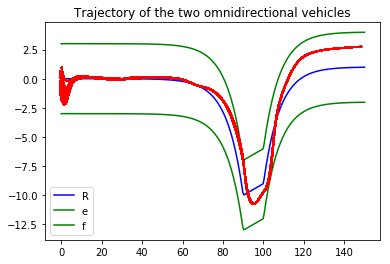

In [580]:
#x0s = []
batch_size = 20
for i_batch in range(batch_size):
    
    x0s.append([x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)])  # Initial state.
    
N = 300
H = 2
agent_traj_ = agent_run(agent_, x0s)
        

print("Done")
draw_agent_traj(agent_traj_)

<h2>MPSC Guided Policy Search</h2>

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=\pi(x_k; \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& \pi(x_k; \theta)\\
u_k + \delta u_k &=& \pi(x_k + \delta x_k; \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x \pi(x_k; \theta) \delta x_k + \nabla_\theta \pi(x_k; \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x \pi(x_k; \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta \pi(x_k; \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.

Previously, we used L-2 norm of the perturbation on the model parameters, i.e. $||\delta \theta||^2_2$, to estimate the loss $L(\delta\theta)$. The optimization problem is as follows.

\begin{eqnarray}
\underset{\delta\theta}{min}&&||\delta \theta||_2^2 \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x \pi(x_k; \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta \pi(x_k; \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

It is a typical Quadratic Programming problem especially if the constrains are all convex. But it would be extremely computationally expensive for traditional QP solver because the size of $\nabla_\theta \pi(x; \theta)$ can be immensively large. 

Considering the difficulty, we can alternate the problem in the following way.

Firstly, given the current model parameter $\theta_i$, the linearization of the perturbation on the learning model can be rearranged in the following way.

$$\delta \theta_i^T \nabla_\theta \pi(x_k; \theta_i) \approx \delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)$$

Let the optimal control at state $x_k$ be $u^*_k$, which can be presumably obtained with the initial model parametere $\theta_0$, i.e. $u^*_k= \pi(x_k; \theta_0)$. The loss of the model based on this specific data point can be evaluated by using square error  
$$J_{(x_k, u^*_k)}(\theta_i) = ||\pi(x_k; \theta_i) - u^*_k||^2_2$$ 
or log likelihood with fixed covariance $\Sigma$
$$J_{(x_k, u^*_k)}(\theta_i) = -log[\frac{1}{(2\pi)^{\frac{n}{2}}\Sigma} exp\{-\frac{1}{2}[\pi(x_k; \theta_i) - u^*_k]^T \Sigma^{-1}[\pi(x_k,\theta_i)-u^*_k]\}$$

Either way, up to a scale of constant, $\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)= \nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k]$.

Evaluating the loss of the model based on a set $D=\{\tau = (x_0, u^*_0, \ldots, x_k, u^*_k, \ldots)\}$ of trajectories sampled from the roll-out of the unchanged model, then the increase on the model's loss due to the perturbation is $J_{D}(\theta_i+\delta\theta_i) - J_{D}(\theta_i)\approx \delta\theta_i^T \nabla_\theta J_{D}(\theta_i) + \frac{1}{2}\delta\theta_i^T \nabla^2_\theta J_{D}(\theta_i)\delta\theta_i$ and it is to be minimized.

Using Fisher Information Matrix to replace the second order derivative, the increase of loss turns out to be
\begin{eqnarray}
&&\delta\theta_i^T \mathbb{E}_{(x_k, u^*_k)\sim D}[\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)] + \frac{1}{2}\delta\theta_i^T \mathbb{E}_{(x_k, u^*_k)\sim D}[\nabla_\theta J_{(x_k, u^*_k)}(\theta_i) \nabla_\theta  J_{(x_k, u^*_k)}(\theta_i)^T]\delta\theta_i\\
&=&\mathbb{E}_{(x_k, u^*_k)\sim D} [\delta\theta_i^T\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)] + \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}[\delta\theta_i^T \nabla_\theta J_{(x_k, u^*_k)}(\theta_i) \nabla_\theta  J_{(x_k, u^*_k)}(\theta_i)^T\delta\theta_i]\\
&=&\mathbb{E}_{(x_k, u^*_k)\sim D} \{\delta\theta_i^T\nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k]\} + \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}\{\delta\theta_i^T \nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k] [\pi(x_k; \theta_i) - u^*_k]^T\nabla_\theta \pi(x_k; \theta_i)^T\delta\theta_i\}\\
&\approx& \mathbb{E}_{(x_k, u^*_k)\sim D}\{[\delta u_k -\delta x_k^T \nabla_x \pi(x_k; \theta_i)][\pi(x_k; \theta_i) - u^*_k]\}+ \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}\{[\delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)][\pi(x_k; \theta_i) - u^*_k] [\pi(x_k; \theta_i) - u^*_k]^T[\delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)]^T\}\\
&\approx& \frac{1}{4|D|} \sum_{(x_k, u^*_k)\in D} \\
&&\begin{bmatrix} 1\\\delta x_k \\ \delta u_k\end{bmatrix}^T 
\begin{bmatrix} 
0 &-2[\pi(x_k; \theta_i) - u^*_k]^T\nabla_x \pi(x_k; \theta_i)^T &  2[\pi(x_k; \theta_i) - u^*_k]^T\\ 
-2\nabla_x \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k] & \nabla_x \pi(x_k; \theta_i) [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \nabla_x \pi(x_k; \theta_i)^T & \nabla_x \pi(x_k; \theta_i) [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \\
2[\pi(x_k; \theta_i) - u^*_k] & [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \nabla_x \pi(x_k; \theta_i)^T & [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T 
\end{bmatrix} 
\begin{bmatrix}1\\\delta x_k \\ \delta u_k\end{bmatrix} 
\end{eqnarray}

As a result, we get a quadratic objective function of which the variables are only $\delta x$ and $\delta u$. As $\pi(,)$ is considered, variable $\delta\theta$ is implicit in this objective function. After solving the $\delta x$ and $\delta u$, $\delta\theta$ can be directly derived and used to modify $\theta_i$. One thing to be stressed is that $\pi(x_k;\theta_i + \delta\theta_i)\neq u_k + \delta u_k$ because $\delta u_k$ is induced by both $\delta x_k$ and $\delta \theta_i$.

If we choose to directly constrain the trajectory, the $UNSAFE()$ function can be rewritten as a barrier function $b:X\rightarrow \mathbb{R}^+$ such that $UNSAFE(x)\leq \Rightarrow b(x)\approx 0$ and $UNSAFE(x)\geq 0 \Rightarrow b(x)\approx \infty$. One candidate is the exponential. Linearize $b$ in the same way as LQR.
\begin{eqnarray}
b(x_k + \delta x_k) = b(x_k) + \delta x_k^T \nabla_x b(x_k) + \delta x_k^T \nabla_x b(x_k) \delta x_k
\end{eqnarray}

For instance, $b(x) = w_1 exp[w_2*UNSAFE(x)]$, the barrier can be written as follows. It can be added to the objective. 
$$b(x_k+\delta x_k) = b(x_k) + \delta x_k^T w_1w_2 exp[w_2 UNSAFE(x)]\nabla_x UNSAFE(x) ^T + \delta x_k^T \{w_1 w_2exp[w_2 UNSAFE(x)]\nabla_{x,x} UNSAFE(x)  + w_1 w_2^2  exp[w_2 UNSAFE(x)]\nabla_x UNSAFE(x) \nabla_x UNSAFE(x)^T\}\delta_x$$

Actually, this constraint will not be needed to be directly enforced in the optimization if the following procedure works.

Firstly we need an initially feasible solution $\delta {\bf x}$ and $\delta {\bf u}$ to ensure the safety of ${\bf x} + \delta{\bf x}$. In fact they can be directly obtained by using MPSC. Once MPSC overrides the learning based controller and invokes a $\delta u_k=u_k^{safe} - u_k$, a safe trajectory ${\bf x} + \delta{\bf x}$ can be obtained in the end. To get $\delta {\bf x}$, the original unsafe trajectory ${\bf x}$ can be simulated at the very first time when MPSC is involved. From the feasible solution, the first feasible $\delta \theta_1$ can be obtained. Henceforth, an iLQR style backward and forward pass can be implemented. 

It is known that the optimal $\delta {\bf u}$ is affine in $\delta {\bf x}$, i.e. $\delta {\bf u} = k + K \delta {\bf x}$. Likewise, $\delta\theta^T \nabla_\theta \pi(x;\theta) = k^T + \delta {\bf x}^T [K^T + \nabla_x \pi(x; \theta)]$ in which $k, K$ should be updated via backward pass while $\delta \theta$ is updated at the end of the forward pass.  

During the forward pass, MPSC should keep monitoring and intervene when necessary. Therefore, the resulted trajectory after a forward pass may not be exctly be induced from the optimal solution. The iteration goes on with safety guarantee and terminates when the changes on $\delta \theta$ and $\delta {\bf x}$ are trivia.

**Initialization**

1. Learning based controller $\pi(;\theta_0)$
2. MPSC verifier

**Iteration** $i$

1. Run $\pi(;\theta_i)$ and the safe controller to generate a safe trajectory $\tau_i$. Train the learning model using $\tau_i$ with an online scheme to obtain $\hat{\theta_i}$ such that all $u$'s in the trajectory equals the outputs of $\pi(;\hat{\theta_i})$ despite some of them are originally generated by the MPSC.
2. Run $\pi(;\theta_0)$ at every state in the trajectory to obtain $u^*$'s.
3. Solve the QP to find $\delta x$'s and $\delta u$'s that should be applied to this trajectory. 
4. Solve $\delta \theta_i$ and add to $\theta_i$ to obtain $\theta_{i+1}$.



In [15]:
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.autograd import Variable
from scipy.linalg import block_diag

from scipy.sparse import coo_matrix, vstack, linalg
from cvxopt import spmatrix, spdiag, matrix, solvers, sparse

n = 2
checkpoint_0 = 'checkpoints/mlp_H2.pt'
paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p']
epoch_init = 0
num_epoch = 10
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

def numpy_sparse_to_spmatrix(X):
    X = coo_matrix(X)
    coo = X.tocoo()
    SP = spmatrix(coo.data.tolist(), coo.row.tolist(), coo.col.tolist(), size = coo.shape)
    return SP

In [16]:
agent_0 = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H2_MPSC_0', \
                      batch_size = 1000, \
                      checkpoint = checkpoint_0)

agent_0.data_process(paths = paths)

if checkpoint_0 is not None:
    checkpoint = torch.load(checkpoint_0, map_location=device)
    agent_0.model.load_state_dict(checkpoint['model_state_dict'])
    agent_0.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_init = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    agent_0.model.eval()
    loss.backward()
    agent_0.optimizer.step()

27416


Done. 5 paths


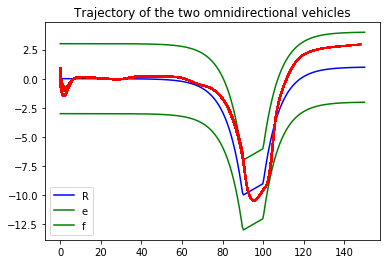

In [18]:
x0s = []
batch_size = 5
for i_batch in range(batch_size):
    x0s.append([x_nominal[0][0] + 0.1 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 0.1 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 0.1 * (2 * random.random() - 1.0)])  # Initial state.

agent = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H2_MPSC', \
                      batch_size = 1000, \
                      checkpoint = 'checkpoints/mlp_temp_H2.pt')
'''
# Run MPSC guided controller and generate safe trajectory
traj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)
draw_agent_traj(traj)
draw_str(nn_traj, mpc_traj)

# Collect training trajectory
train_traj_aggr = [i for i in train_traj[:]] * 100
itr = 0

while itr < 1:
    train_traj = train_temp(agent, x0s, train_traj_aggr, paths = None)
    train_traj_aggr = train_traj_aggr + [i for i in train_traj[:]] * 100
    itr += 1
'''

agent_traj = agent_run(agent, x0s) 
print("Done. {} paths".format(len(agent_traj)))
draw_agent_traj(agent_traj)


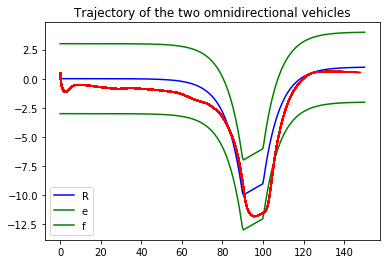

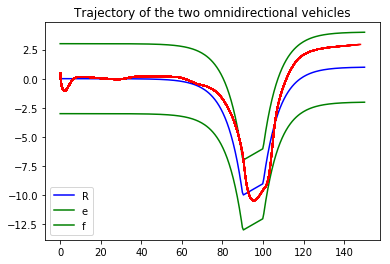

>>>>>>>>>>>>>>>>>>>>
Start epoch 0
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


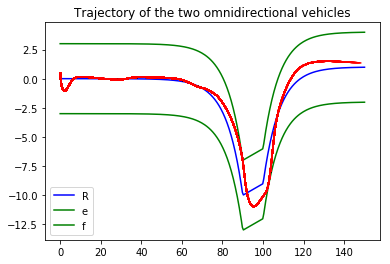

1
290
[Epoch 1] avg_loss: 0.012
[Epoch 51] avg_loss: 0.000
Finished Training


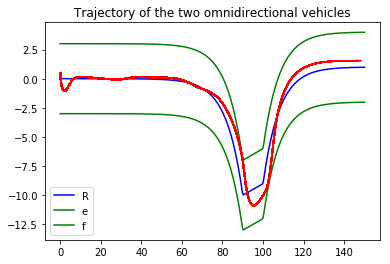

>>>>>Step 0 at [0.08853465647845826, 0.4534789832694357, 10.0253917477263, -1.2750134213262823]
Utilize NN output [[0.09724317 0.7752279 ]]
>>>>>Step 1 at [ 0.23468447 -0.0261385  10.03023864 -0.94920869]
Utilize NN output [[0.08188334 0.63951993]]
>>>>>Step 2 at [ 0.52678767 -0.43392813 10.03432368 -0.6660688 ]
Utilize NN output [[0.11316531 0.5566872 ]]
>>>>>Step 3 at [ 0.92137619 -0.74402551 10.03995791 -0.41244358]
Utilize NN output [[0.07723361 0.45597675]]
>>>>>Step 4 at [ 1.38136685 -0.94528958 10.04381193 -0.19819113]
Utilize NN output [[0.08975209 0.37652603]]
>>>>>Step 5 at [ 1.87383643 -1.04419103 10.04828753 -0.01755984]
Utilize NN output [[0.09698583 0.28938815]]
>>>>>Step 6 at [ 2.37629418 -1.05301502 10.05312167  0.12390576]
Utilize NN output [[0.10012546 0.20078197]]
>>>>>Step 7 at [ 2.87522044 -0.99087686 10.05811128  0.22349536]
Utilize NN output [[0.10070925 0.11913622]]
>>>>>Step 8 at [ 3.36574043 -0.87938537 10.06312979  0.28312776]
Utilize NN output [[0.09975914 0

Utilize NN output [[ 0.17360851 -0.01936183]]
>>>>>Step 125 at [64.04416718 -0.38670356 10.8322463  -0.08686936]
Utilize NN output [[ 0.16049732 -0.01433403]]
>>>>>Step 126 at [64.58393536 -0.43371118 10.84020296 -0.09463232]
Utilize NN output [[ 0.14868867 -0.01051373]]
>>>>>Step 127 at [65.12370407 -0.48494377 10.84758309 -0.10033066]
Utilize NN output [[0.13882948 0.0005488 ]]
>>>>>Step 128 at [65.66352722 -0.53928705 10.85448031 -0.100033  ]
Utilize NN output [[0.13007893 0.00816288]]
>>>>>Step 129 at [66.20369897 -0.593503   10.86094782 -0.09560291]
Utilize NN output [[0.12213531 0.01279593]]
>>>>>Step 130 at [66.74441777 -0.64535536 10.8670244  -0.08865449]
Utilize NN output [[0.11477687 0.0149634 ]]
>>>>>Step 131 at [67.2857774  -0.69347546 10.87273817 -0.08052471]
Utilize NN output [[0.10785987 0.01518496]]
>>>>>Step 132 at [67.8277866  -0.73721518 10.87811035 -0.07227025]
Utilize NN output [[0.10129519 0.01394926]]
>>>>>Step 133 at [ 6.83703982e+01 -7.76498264e-01  1.08831579e

Utilize NN output [[0.01669855 0.00087043]]
>>>>>Step 253 at [1.28048812e+02 1.37678079e+00 1.12673232e+01 3.38460983e-02]
Utilize NN output [[ 0.03273286 -0.01558026]]
>>>>>Step 254 at [1.28611897e+02 1.39584628e+00 1.12689593e+01 2.50694144e-02]
Utilize NN output [[ 0.02932185 -0.00997305]]
>>>>>Step 255 at [1.29175204e+02 1.40997103e+00 1.12704250e+01 1.94503038e-02]
Utilize NN output [[ 0.02630926 -0.00534897]]
>>>>>Step 256 at [1.29738652e+02 1.42093164e+00 1.12717401e+01 1.64360763e-02]
Utilize NN output [[ 0.02363919 -0.00176272]]
>>>>>Step 257 at [1.30302192e+02 1.43019486e+00 1.12729219e+01 1.54426293e-02]
Utilize NN output [[0.02126335 0.00082424]]
>>>>>Step 258 at [1.30865798e+02 1.43889910e+00 1.12739849e+01 1.59072061e-02]
Utilize NN output [[0.01914185 0.0025089 ]]
>>>>>Step 259 at [1.31429449e+02 1.44786599e+00 1.12749418e+01 1.73214658e-02]
Utilize NN output [[0.01724185 0.00342418]]
>>>>>Step 260 at [1.31993134e+02 1.45763080e+00 1.12758038e+01 1.92518279e-02]
Utilize 

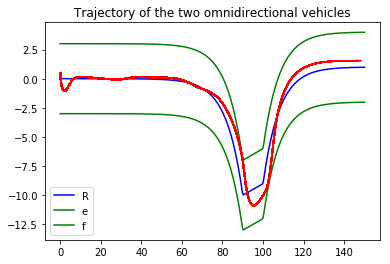

No intervention. Agent is clear.


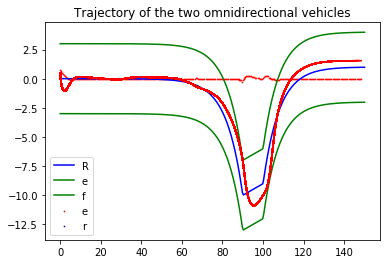

<<<<<<<<<<<<<<<<<<<<
Finished epoch 0




>>>>>>>>>>>>>>>>>>>>
Start epoch 1
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


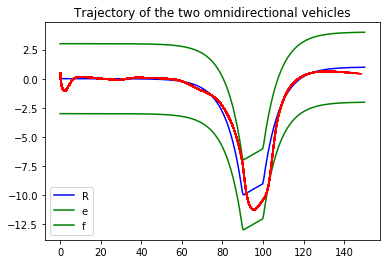

1
290
[Epoch 1] avg_loss: 0.005
[Epoch 51] avg_loss: 0.000
Finished Training


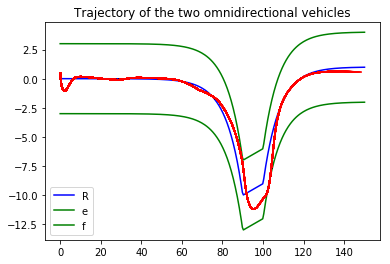

>>>>>Step 0 at [0.08853465647845826, 0.4534789832694357, 10.0253917477263, -1.2750134213262823]
Utilize NN output [[0.09799787 0.781343  ]]
>>>>>Step 1 at [ 0.23468474 -0.02613939 10.03027602 -0.94744534]
Utilize NN output [[0.08199183 0.6432488 ]]
>>>>>Step 2 at [ 0.52750773 -0.43341494 10.03436645 -0.66303307]
Utilize NN output [[0.11290519 0.5588887 ]]
>>>>>Step 3 at [ 0.92303723 -0.74231415 10.03998784 -0.40858542]
Utilize NN output [[0.07678072 0.45658842]]
>>>>>Step 4 at [ 1.38380183 -0.94180238 10.04381935 -0.19408128]
Utilize NN output [[0.08908846 0.3764282 ]]
>>>>>Step 5 at [ 1.87667328 -1.03867893 10.04826202 -0.01349263]
Utilize NN output [[0.09621421 0.28874996]]
>>>>>Step 6 at [ 2.37916054 -1.04545922 10.05305795  0.12767735]
Utilize NN output [[0.0993067 0.1996992]]
>>>>>Step 7 at [ 2.87784472 -0.9814403  10.05800702  0.2267433 ]
Utilize NN output [[0.09988891 0.11776697]]
>>>>>Step 8 at [ 3.36799394 -0.86835762 10.06298492  0.28569607]
Utilize NN output [[0.0989621  0.0

Utilize NN output [[ 0.13866717 -0.00788543]]
>>>>>Step 128 at [65.65843488 -0.67834336 10.85357653 -0.10751391]
Utilize NN output [[ 0.12924671 -0.00210754]]
>>>>>Step 129 at [66.19813999 -0.73659378 10.86000312 -0.10865762]
Utilize NN output [[0.12113432 0.0063902 ]]
>>>>>Step 130 at [66.73808763 -0.79549519 10.86603039 -0.10518779]
Utilize NN output [[0.11381193 0.01174385]]
>>>>>Step 131 at [67.27852712 -0.85255343 10.87169654 -0.09880763]
Utilize NN output [[0.10705241 0.01447065]]
>>>>>Step 132 at [67.81959327 -0.90618955 10.87702881 -0.09094215]
Utilize NN output [[0.10070448 0.01509827]]
>>>>>Step 133 at [68.36132224 -0.95559182 10.88204708 -0.08273156]
Utilize NN output [[0.09467762 0.0141325 ]]
>>>>>Step 134 at [68.90368119 -1.00056467 10.88676686 -0.07504254]
Utilize NN output [[0.0889214  0.01202941]]
>>>>>Step 135 at [ 6.94465981e+01 -1.04138319e+00  1.08912013e+01 -6.84947901e-02]
Utilize NN output [[0.08341201 0.00919198]]
>>>>>Step 136 at [ 6.99899850e+01 -1.07866068e+0

Utilize NN output [[ 0.05291845 -0.02783394]]
>>>>>Step 205 at [103.78574698  -7.46783864  11.20962746   0.95424893]
Utilize NN output [[ 0.06618024 -0.00574968]]
>>>>>Step 206 at [104.10987724  -7.01048588  11.21293165   0.95102637]
Utilize NN output [[0.08130585 0.0058421 ]]
>>>>>Step 207 at [104.43558654  -6.55403023  11.21698801   0.95430169]
Utilize NN output [[ 0.04720944 -0.05796887]]
>>>>>Step 208 at [104.75989179  -6.09637937  11.21934673   0.92182625]
Utilize NN output [[ 0.05781879 -0.03600017]]
>>>>>Step 209 at [105.0989651   -5.64939544  11.22223445   0.90164005]
Utilize NN output [[ 0.07050553 -0.0345824 ]]
>>>>>Step 210 at [105.447091    -5.20922107  11.2257539    0.8822432 ]
Utilize NN output [[ 0.04037336 -0.10294842]]
>>>>>Step 211 at [105.80377682  -4.77577474  11.22777147   0.82466279]
Utilize NN output [[ 0.04818076 -0.09071454]]
>>>>>Step 212 at [106.18489083  -4.36349229  11.23017865   0.77387592]
Utilize NN output [[ 0.0554614 -0.0817273]]
>>>>>Step 213 at [106.

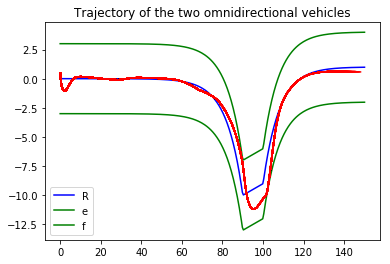

Intervention identified. Retrain agent in the pipeline.
1
289
[Epoch 1] avg_loss: 0.001
[Epoch 51] avg_loss: 0.001
Finished Training


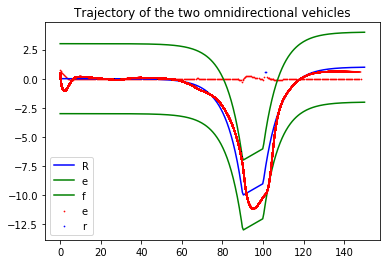

>>>>>Step 0 at [0.08853465647845826, 0.4534789832694357, 10.0253917477263, -1.2750134213262823]
Utilize NN output [[0.09559754 0.7810598 ]]
>>>>>Step 1 at [ 0.23468388 -0.02613655 10.03015712 -0.94752669]
Utilize NN output [[0.08008913 0.643405  ]]
>>>>>Step 2 at [ 0.52746888 -0.43342917 10.03415303 -0.66306465]
Utilize NN output [[0.11043327 0.5588465 ]]
>>>>>Step 3 at [ 0.92297782 -0.74233242 10.03965236 -0.40863813]
Utilize NN output [[0.07519744 0.4569861 ]]
>>>>>Step 4 at [ 1.3837147  -0.94183749 10.04340516 -0.193978  ]
Utilize NN output [[0.08728917 0.3765814 ]]
>>>>>Step 5 at [ 1.87657364 -1.03865872 10.04775857 -0.01332982]
Utilize NN output [[0.09433618 0.2887394 ]]
>>>>>Step 6 at [ 2.3790345  -1.04535683 10.05246143  0.1278282 ]
Utilize NN output [[0.09741291 0.19953407]]
>>>>>Step 7 at [ 2.87767711 -0.98126679 10.05731673  0.22680851]
Utilize NN output [[0.09801343 0.11748768]]
>>>>>Step 8 at [ 3.36778306 -0.86816042 10.06220177  0.28561871]
Utilize NN output [[0.09712203 0

Utilize NN output [[0.1327599  0.00711908]]
>>>>>Step 130 at [66.72058188 -0.76975446 10.86714715 -0.10295156]
Utilize NN output [[0.12470891 0.01209491]]
>>>>>Step 131 at [67.26121651 -0.82561113 10.87335047 -0.09638002]
Utilize NN output [[0.11726235 0.01452742]]
>>>>>Step 132 at [67.80250613 -0.87794277 10.87918686 -0.08848249]
Utilize NN output [[0.11026151 0.01493649]]
>>>>>Step 133 at [68.34447422 -0.926023   10.8846777  -0.08035825]
Utilize NN output [[0.10361646 0.01381952]]
>>>>>Step 134 at [68.88708051 -0.96971999 10.88984006 -0.07283768]
Utilize NN output [[0.09727466 0.01162962]]
>>>>>Step 135 at [ 6.94302497e+01 -1.00935328e+00  1.08946885e+01 -6.65057291e-02]
Utilize NN output [[0.09121087 0.0087497 ]]
>>>>>Step 136 at [ 6.99738933e+01 -1.04556210e+00  1.08992365e+01 -6.17395874e-02]
Utilize NN output [[0.08546028 0.00550553]]
>>>>>Step 137 at [ 7.05179232e+01 -1.07919302e+00  1.09034991e+01 -5.87393147e-02]
Utilize NN output [[ 0.15706827 -0.02021997]]
>>>>>Step 138 at [

Utilize NN output [[ 0.0250441  -0.01830815]]
>>>>>Step 232 at [116.45727985  -0.29434557  11.28316378   0.15433833]
Utilize NN output [[ 0.0226116  -0.01770026]]
>>>>>Step 233 at [117.01476007  -0.20761526  11.28429417   0.14435362]
Utilize NN output [[ 0.04411007 -0.02436442]]
>>>>>Step 234 at [117.57316097  -0.12644347  11.28649825   0.13060958]
Utilize NN output [[ 0.03961171 -0.02178879]]
>>>>>Step 235 at [ 1.18132728e+02 -5.29401612e-02  1.12884778e+01  1.18315565e-01]
Utilize NN output [[ 0.03555547 -0.01913928]]
>>>>>Step 236 at [1.18693250e+02 1.36895187e-02 1.12902548e+01 1.07514214e-01]
Utilize NN output [[ 0.03191302 -0.01657549]]
>>>>>Step 237 at [1.19254543e+02 7.42700809e-02 1.12918499e+01 9.81579933e-02]
Utilize NN output [[ 0.02864443 -0.01420862]]
>>>>>Step 238 at [1.19816454e+02 1.29603904e-01 1.12932818e+01 9.01364532e-02]
Utilize NN output [[ 0.02571531 -0.01210774]]
>>>>>Step 239 at [1.20378858e+02 1.80434724e-01 1.12945672e+01 8.32999801e-02]
Utilize NN output [[

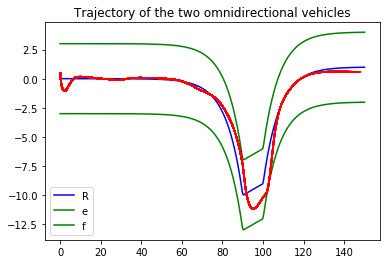

Intervention identified. Retrain agent in the pipeline.
1
289
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
Finished Training


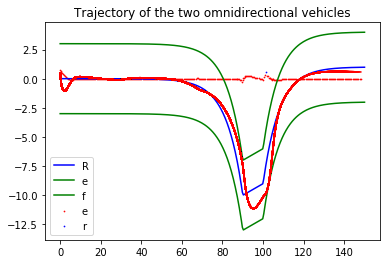

>>>>>Step 0 at [0.08853465647845826, 0.4534789832694357, 10.0253917477263, -1.2750134213262823]
Utilize NN output [[0.09440929 0.7808103 ]]
>>>>>Step 1 at [ 0.23468345 -0.02613514 10.03009824 -0.94759839]
Utilize NN output [[0.07915946 0.64340794]]
>>>>>Step 2 at [ 0.52743686 -0.43344542 10.03404796 -0.66313702]
Utilize NN output [[0.10923857 0.5588011 ]]
>>>>>Step 3 at [ 0.92291813 -0.74237316 10.03948827 -0.40873007]
Utilize NN output [[0.07444721 0.45718127]]
>>>>>Step 4 at [ 1.38362829 -0.94191696 10.04320377 -0.19399341]
Utilize NN output [[0.08644181 0.37668154]]
>>>>>Step 5 at [ 1.87647482 -1.03874364 10.04751513 -0.01330507]
Utilize NN output [[0.09345777 0.28876433]]
>>>>>Step 6 at [ 2.37892259 -1.04542914 10.05217446  0.12786106]
Utilize NN output [[0.09653195 0.19948466]]
>>>>>Step 7 at [ 2.87754778 -0.98132467 10.05698612  0.22681467]
Utilize NN output [[0.09714393 0.11738104]]
>>>>>Step 8 at [ 3.36763587 -0.86821925 10.06182809  0.28557004]
Utilize NN output [[0.09627121 0

Utilize NN output [[0.1270824  0.01250676]]
>>>>>Step 131 at [67.2631638  -0.81706143 10.8778589  -0.09452202]
Utilize NN output [[0.11947871 0.01466274]]
>>>>>Step 132 at [67.80477685 -0.8684088  10.88380457 -0.08654763]
Utilize NN output [[0.11232544 0.01486178]]
>>>>>Step 133 at [68.34706952 -0.91546049 10.88939734 -0.07846059]
Utilize NN output [[0.10553247 0.01359627]]
>>>>>Step 134 at [68.88999537 -0.9581464  10.89465446 -0.07105829]
Utilize NN output [[0.09904864 0.01130814]]
>>>>>Step 135 at [ 6.94334765e+01 -9.96830368e-01  1.08995908e+01 -6.48986387e-02]
Utilize NN output [[0.09284953 0.00837593]]
>>>>>Step 136 at [ 6.99774243e+01 -1.03218148e+00  1.09042199e+01 -6.03340332e-02]
Utilize NN output [[0.08696891 0.00511622]]
>>>>>Step 137 at [ 7.05217515e+01 -1.06506284e+00  1.09085575e+01 -5.75446398e-02]
Utilize NN output [[ 0.15962733 -0.02057229]]
>>>>>Step 138 at [ 7.10664741e+01 -1.09644336e+00  1.09164717e+01 -6.87637554e-02]
Utilize NN output [[ 0.14748418 -0.01714946]]


Utilize NN output [[0.02189298 0.00405385]]
>>>>>Step 262 at [1.33419884e+02 6.01605505e-01 1.13288176e+01 6.52164745e-03]
Utilize NN output [[0.0196668  0.00481069]]
>>>>>Step 263 at [1.33986338e+02 6.05299767e-01 1.13298008e+01 9.24659841e-03]
Utilize NN output [[0.01767166 0.00491744]]
>>>>>Step 264 at [1.34552826e+02 6.10538003e-01 1.13306843e+01 1.20322570e-02]
Utilize NN output [[ 0.03452439 -0.01408134]]
>>>>>Step 265 at [1.35119362e+02 6.17355043e-01 1.13324099e+01 4.05522053e-03]
Utilize NN output [[ 0.03081258 -0.00823171]]
>>>>>Step 266 at [ 1.35686016e+02  6.19652964e-01  1.13339500e+01 -6.08932183e-04]
Utilize NN output [[ 0.02755318 -0.00346608]]
>>>>>Step 267 at [ 1.36252748e+02  6.19307862e-01  1.13353273e+01 -2.57314210e-03]
Utilize NN output [[0.02467689 0.00016091]]
>>>>>Step 268 at [ 1.36819544e+02  6.17849414e-01  1.13365609e+01 -2.48194362e-03]
Utilize NN output [[0.02212591 0.00271019]]
>>>>>Step 269 at [ 1.37386398e+02  6.16442512e-01  1.13376670e+01 -9.45733227

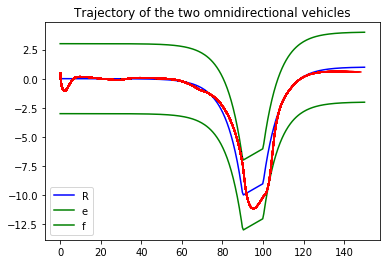

No intervention. Agent is clear.


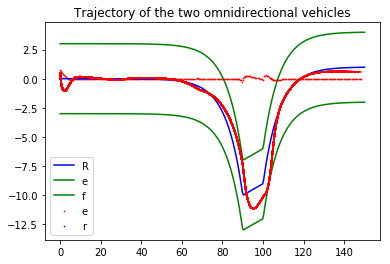

<<<<<<<<<<<<<<<<<<<<
Finished epoch 1




>>>>>>>>>>>>>>>>>>>>
Start epoch 2
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 60 [Unsafe]
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


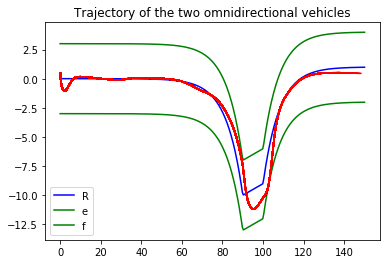

1
289
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
Finished Training


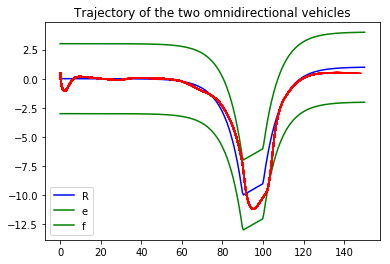

>>>>>Step 0 at [0.08853465647845826, 0.4534789832694357, 10.0253917477263, -1.2750134213262823]
Utilize NN output [[0.09451889 0.781543  ]]
>>>>>Step 1 at [ 0.23468349 -0.02613527 10.03010367 -0.9473879 ]
Utilize NN output [[0.07920382 0.64393103]]
>>>>>Step 2 at [ 0.52752281 -0.43338419 10.0340556  -0.6627485 ]
Utilize NN output [[0.10926847 0.559168  ]]
>>>>>Step 3 at [ 0.92312442 -0.7421585  10.03949738 -0.40820465]
Utilize NN output [[0.07444374 0.45736477]]
>>>>>Step 4 at [ 1.38393977 -0.94146039 10.04321271 -0.19339254]
Utilize NN output [[0.0864253  0.37673357]]
>>>>>Step 5 at [ 1.87684481 -1.037991   10.04752325 -0.0126813 ]
Utilize NN output [[0.09342954 0.28869903]]
>>>>>Step 6 at [ 2.37929702 -1.04436309 10.05218118  0.12845473]
Utilize NN output [[0.09649561 0.1993206 ]]
>>>>>Step 7 at [ 2.87788435 -0.97996258 10.05699104  0.22732914]
Utilize NN output [[0.09710237 0.11715012]]
>>>>>Step 8 at [ 3.36791439 -0.86660499 10.06183096  0.28597001]
Utilize NN output [[0.0962259  0

Utilize NN output [[ 0.14405972 -0.00120541]]
>>>>>Step 129 at [66.18044798 -0.72498233 10.86420269 -0.10700982]
Utilize NN output [[0.13501081 0.00692798]]
>>>>>Step 130 at [66.72071769 -0.78301818 10.87091251 -0.10324653]
Utilize NN output [[0.12682015 0.01198422]]
>>>>>Step 131 at [67.26152567 -0.83905399 10.87721974 -0.09673287]
Utilize NN output [[0.11924881 0.01447791]]
>>>>>Step 132 at [67.80299179 -0.89159554 10.88315408 -0.08885945]
Utilize NN output [[0.1121345  0.01493376]]
>>>>>Step 133 at [68.3451416  -0.93989788 10.88873742 -0.08073374]
Utilize NN output [[0.10538252 0.01384948]]
>>>>>Step 134 at [68.88793595 -0.98381515 10.89398713 -0.07319405]
Utilize NN output [[0.09893762 0.01167772]]
>>>>>Step 135 at [ 6.94312998e+01 -1.02365733e+00  1.08989179e+01 -6.68334986e-02]
Utilize NN output [[0.09277733 0.00880907]]
>>>>>Step 136 at [ 6.99751445e+01 -1.06005859e+00  1.09035435e+01 -6.20331562e-02]
Utilize NN output [[0.08693948 0.00557077]]
>>>>>Step 137 at [ 7.05193812e+01 

Utilize NN output [[0.02017586 0.00468209]]
>>>>>Step 262 at [1.33468764e+02 5.01329392e-01 1.13316489e+01 9.39063010e-03]
Utilize NN output [[0.01812519 0.00480243]]
>>>>>Step 263 at [1.34035344e+02 5.06650092e-01 1.13325550e+01 1.21115809e-02]
Utilize NN output [[ 0.03538775 -0.01418531]]
>>>>>Step 264 at [1.34601975e+02 5.13513218e-01 1.13343237e+01 4.07432899e-03]
Utilize NN output [[ 0.03157567 -0.0083261 ]]
>>>>>Step 265 at [ 1.35168726e+02  5.15822361e-01  1.13359020e+01 -6.44097178e-04]
Utilize NN output [[ 0.02822836 -0.00355433]]
>>>>>Step 266 at [ 1.35735556e+02  5.15457267e-01  1.13373130e+01 -2.65866510e-03]
Utilize NN output [[2.5276026e-02 8.1837177e-05]]
>>>>>Step 267 at [ 1.36302451e+02  5.13950079e-01  1.13385765e+01 -2.61227442e-03]
Utilize NN output [[0.02265898 0.0026344 ]]
>>>>>Step 268 at [ 1.36869406e+02  5.12469033e-01  1.13397093e+01 -1.11876055e-03]
Utilize NN output [[0.0203294  0.00423018]]
>>>>>Step 269 at [1.37436417e+02 5.11834683e-01 1.13407256e+01 1.27

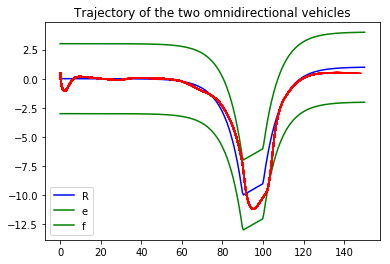

No intervention. Agent is clear.


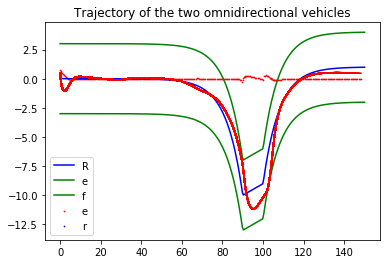

<<<<<<<<<<<<<<<<<<<<
Finished epoch 2




>>>>>>>>>>>>>>>>>>>>
Start epoch 3
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


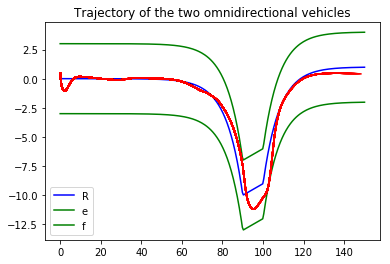

1
289
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
Finished Training


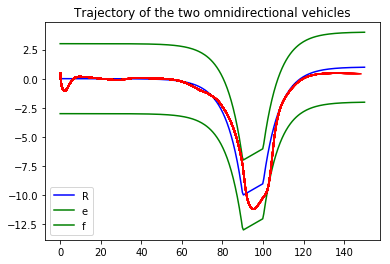

>>>>>Step 0 at [0.08853465647845826, 0.4534789832694357, 10.0253917477263, -1.2750134213262823]
Utilize NN output [[0.09458034 0.7818396 ]]
>>>>>Step 1 at [ 0.23468351 -0.02613534 10.03010671 -0.94730275]
Utilize NN output [[0.07923091 0.64411986]]
>>>>>Step 2 at [ 0.52755762 -0.43335948 10.03405999 -0.66259908]
Utilize NN output [[0.10928941 0.55928755]]
>>>>>Step 3 at [ 0.92320555 -0.74207483 10.03950281 -0.40801058]
Utilize NN output [[0.07444145 0.45739785]]
>>>>>Step 4 at [ 1.38405981 -0.94128739 10.04321802 -0.19318479]
Utilize NN output [[0.0864164  0.37672663]]
>>>>>Step 5 at [ 1.87698515 -1.03771564 10.04752812 -0.01247648]
Utilize NN output [[0.09341664 0.28865993]]
>>>>>Step 6 at [ 2.37943888 -1.04398482 10.05218541  0.12864152]
Utilize NN output [[0.09648    0.19925494]]
>>>>>Step 7 at [ 2.87801437 -0.97949116 10.0569945   0.22748425]
Utilize NN output [[0.09708603 0.11706924]]
>>>>>Step 8 at [ 3.36802696 -0.86605753 10.0618336   0.28608502]
Utilize NN output [[0.09620982 0

Utilize NN output [[ 0.15533099 -0.00304223]]
>>>>>Step 107 at [ 5.43419724e+01 -5.95623918e-02  1.06968944e+01 -2.01892267e-02]
Utilize NN output [[ 0.14897269 -0.00326697]]
>>>>>Step 108 at [ 5.48768929e+01 -7.03634912e-02  1.07042884e+01 -2.19365427e-02]
Utilize NN output [[ 0.14288478 -0.00337924]]
>>>>>Step 109 at [ 5.54121559e+01 -8.21071948e-02  1.07113844e+01 -2.37451513e-02]
Utilize NN output [[ 0.13705973 -0.0034141 ]]
>>>>>Step 110 at [ 5.59477443e+01 -9.48272144e-02  1.07181948e+01 -2.55736329e-02]
Utilize NN output [[ 0.13148823 -0.00340558]]
>>>>>Step 111 at [ 5.64836422e+01 -1.08535058e-01  1.07247316e+01 -2.73987094e-02]
Utilize NN output [[ 0.12615722 -0.00337596]]
>>>>>Step 112 at [ 5.70198343e+01 -1.23229708e-01  1.07310062e+01 -2.92090142e-02]
Utilize NN output [[ 0.23456329 -0.01175417]]
>>>>>Step 113 at [ 5.75564436e+01 -1.38907994e-01  1.07425239e+01 -3.55154288e-02]
Utilize NN output [[ 0.21761109 -0.01101151]]
>>>>>Step 114 at [ 5.80934987e+01 -1.57989760e-01  

Utilize NN output [[ 0.05628445 -0.02263078]]
>>>>>Step 223 at [111.57652123  -1.43565501  11.27060691   0.24867451]
Utilize NN output [[ 0.05140359 -0.02067238]]
>>>>>Step 224 at [112.12277932  -1.29694343  11.27317483   0.23702665]
Utilize NN output [[ 0.04687514 -0.01951997]]
>>>>>Step 225 at [112.67073533  -1.16457502  11.27551687   0.22602545]
Utilize NN output [[ 0.04268436 -0.01891974]]
>>>>>Step 226 at [113.2202234   -1.03821761  11.2776498    0.21536023]
Utilize NN output [[ 0.03881434 -0.01866591]]
>>>>>Step 227 at [113.77112728  -0.91770593  11.27958954   0.20483607]
Utilize NN output [[ 0.03524578 -0.01858523]]
>>>>>Step 228 at [114.32335951  -0.80297979  11.2813511    0.19435559]
Utilize NN output [[ 0.03196285 -0.01854436]]
>>>>>Step 229 at [114.87684618  -0.69403128  11.2829487    0.18389652]
Utilize NN output [[ 0.02894845 -0.01844944]]
>>>>>Step 230 at [115.43151688  -0.59086367  11.28439572   0.17348949]
Utilize NN output [[ 0.02618713 -0.01824405]]
>>>>>Step 231 at [

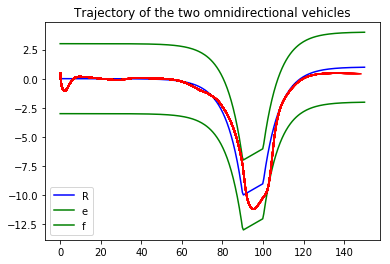

No intervention. Agent is clear.


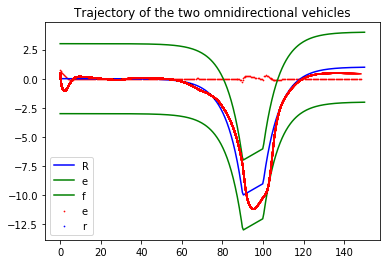

<<<<<<<<<<<<<<<<<<<<
Finished epoch 3




>>>>>>>>>>>>>>>>>>>>
Start epoch 4
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 10 [Unsafe]
Finished iteration 20 [Unsafe]
Finished iteration 30 [Unsafe]
Finished iteration 40 [Unsafe]
Finished iteration 50 [Unsafe]
Finished iteration 60 [Unsafe]
Found new optimal solution. Load QP parameters.
Finished iteration 70 [Unsafe]
Finished iteration 80 [Unsafe]
Finished iteration 90 [Unsafe]


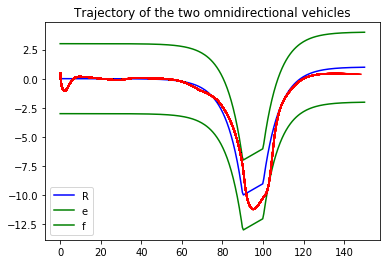

1
289
[Epoch 1] avg_loss: 0.000
[Epoch 51] avg_loss: 0.000
Finished Training


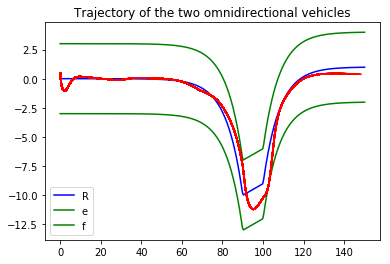

>>>>>Step 0 at [0.08853465647845826, 0.4534789832694357, 10.0253917477263, -1.2750134213262823]
Utilize NN output [[0.09461449 0.78206   ]]
>>>>>Step 1 at [ 0.23468352 -0.02613538 10.03010841 -0.94723949]
Utilize NN output [[0.07924114 0.644261  ]]
>>>>>Step 2 at [ 0.52758345 -0.43334107 10.03406219 -0.66248781]
Utilize NN output [[0.10929122 0.5593754 ]]
>>>>>Step 3 at [ 0.92326581 -0.74201246 10.0395051  -0.40786653]
Utilize NN output [[0.07443088 0.45742387]]
>>>>>Step 4 at [ 1.38414886 -0.94115867 10.04321979 -0.19303002]
Utilize NN output [[0.08639942 0.37672278]]
>>>>>Step 5 at [ 1.87708919 -1.03751065 10.04752904 -0.01232336]
Utilize NN output [[0.09339581 0.28863168]]
>>>>>Step 6 at [ 2.37954389 -1.04370289 10.0521853   0.12878159]
Utilize NN output [[0.09645754 0.19920753]]
>>>>>Step 7 at [ 2.87811031 -0.9791394  10.05699327  0.2276014 ]
Utilize NN output [[0.09706331 0.11701043]]
>>>>>Step 8 at [ 3.36810952 -0.86564839 10.06183126  0.28617299]
Utilize NN output [[0.09618802 0

Utilize NN output [[ 0.12209042 -0.00526315]]
>>>>>Step 122 at [62.40118166 -0.41036971 10.8161292  -0.07301925]
Utilize NN output [[ 0.113893  -0.0050841]]
>>>>>Step 123 at [62.9406884  -0.44983426 10.82179935 -0.07576874]
Utilize NN output [[ 0.10629187 -0.0050245 ]]
>>>>>Step 124 at [63.48035792 -0.49080277 10.82709402 -0.07848742]
Utilize NN output [[ 0.09924014 -0.00506917]]
>>>>>Step 125 at [64.0201693  -0.53325839 10.8320398  -0.08123162]
Utilize NN output [[ 0.1800931  -0.02044284]]
>>>>>Step 126 at [64.56020735 -0.57722329 10.84094835 -0.09230196]
Utilize NN output [[ 0.16653024 -0.01520223]]
>>>>>Step 127 at [65.10015276 -0.62720333 10.84919874 -0.10054165]
Utilize NN output [[ 0.15432622 -0.01125915]]
>>>>>Step 128 at [65.64006367 -0.68167052 10.85685437 -0.10664904]
Utilize NN output [[ 0.1439053  -0.00236557]]
>>>>>Step 129 at [66.17999979 -0.73947351 10.86400037 -0.10793317]
Utilize NN output [[0.13483046 0.0061534 ]]
>>>>>Step 130 at [66.72020541 -0.79800708 10.87070134 

Utilize NN output [[ 0.02723162 -0.00292364]]
>>>>>Step 252 at [1.27814668e+02 3.76020054e-01 1.13176569e+01 1.63525573e-02]
Utilize NN output [[ 0.02442677 -0.00028001]]
>>>>>Step 253 at [1.28380506e+02 3.85273773e-01 1.13188780e+01 1.61941057e-02]
Utilize NN output [[0.02192958 0.00146957]]
>>>>>Step 254 at [1.28946403e+02 3.94438771e-01 1.13199743e+01 1.70257973e-02]
Utilize NN output [[0.01969879 0.00246448]]
>>>>>Step 255 at [1.29512344e+02 4.04075304e-01 1.13209591e+01 1.84206888e-02]
Utilize NN output [[ 0.03840679 -0.01491476]]
>>>>>Step 256 at [1.30078344e+02 4.14502592e-01 1.13228785e+01 9.97884407e-03]
Utilize NN output [[ 0.03428983 -0.0088514 ]]
>>>>>Step 257 at [1.30644503e+02 4.20152387e-01 1.13245924e+01 4.96780773e-03]
Utilize NN output [[ 0.03067254 -0.0039508 ]]
>>>>>Step 258 at [1.31210764e+02 4.22965486e-01 1.13261255e+01 2.73076003e-03]
Utilize NN output [[ 0.02747936 -0.00023828]]
>>>>>Step 259 at [1.31777102e+02 4.24512025e-01 1.13274991e+01 2.59581804e-03]
Util

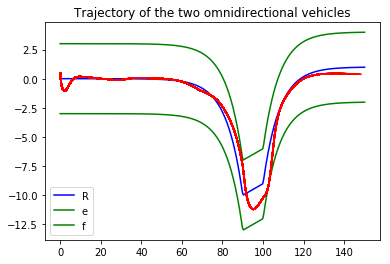

No intervention. Agent is clear.


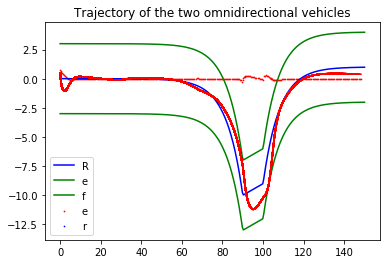

<<<<<<<<<<<<<<<<<<<<
Finished epoch 4






In [49]:
def QP(P_qp, q_qp, G_qp, h_qp, A_qp = None, b_qp = None):
    P_qp = numpy_sparse_to_spmatrix(P_qp)
    q_qp = matrix(q_qp)
    G_qp = numpy_sparse_to_spmatrix(G_qp)
    h_qp = matrix(h_qp)
    print("Starting solving QP")
    solvers.options['feastol'] = 1e-5
    sol=solvers.qp(P_qp, q_qp, G_qp, h_qp, A_qp, b_qp)
    #sol = {'x': [0.0 for i in range(dynamics.state_size * (N - n + 1) + agent.num_parameters(agent.model))]}
    theta_diffs = list(sol['x'])
    if theta_diffs is None:
        theta_diffs = np.zeros(agent.num_parameters(agent.model))
    return theta_diffs


x0s = x0s[:1]

#  # loop over the dataset multiple times 
agent_0 = NeuralNetwork(input_size = (n + 1) * dynamics.state_size, \
                      model_name = 'mlp_H2_MPSC_0', \
                      batch_size = 1000, \
                      checkpoint = checkpoint_0)

agent_traj_0 = agent_run(agent_0, x0s)
draw_agent_traj(agent_traj_0)

agent = NeuralNetwork(input_size = (n + 1) * dynamics.state_size, \
                      model_name = 'mlp_H2_MPSC_1', \
                      batch_size = 1000, \
                      checkpoint = 'checkpoints/mlp_temp_H2.pt')
agent_traj = agent_run(agent, x0s)
draw_agent_traj(agent_traj)

data_trajs = agent_traj

num_epoch = 5
tol = 1e-5

for epoch in range(num_epoch):
    print(">>>>>>>>>>>>>>>>>>>>")
    print("Start epoch {}".format(epoch))
    # Initialize Q matrix 
    Q1 = []
    Qx = []
    Qu = []
    Qx_T = []
    Qu_T = []
    Qxx = []
    Quu = []
    Qux = []
    Qxu = []

    # Initialize K, k
    K = []
    k = []

    # Run the latest model and original model to get (pi_\theta - u^*)
    u_diffs = []
    # Run the latest model to get gradient on the input x   
    pix = []
    # Run the latest model to get gradient on \theta
    pitheta = []

    # Barrier 1st order and 2nd order
    b1 = []
    bx = []
    bx_T = []
    bxx = []

    xs_diff = []
    us_diff = []
        
    h_qp = []
    G_qp = []
    
    theta_diffs = np.zeros([len(data_trajs), agent.num_parameters(agent.model)])
    P_qp = np.eye(agent.num_parameters(agent.model))
    q_qp = np.zeros([agent.num_parameters(agent.model), 1])
    
    num_itr = 10
    
    for i_traj in range(len(data_trajs)):
        print("Optimize rajectory {}".format(i_traj))
        Q1.append(np.empty([len(data_trajs[i_traj]), 1, 1]))
        Qx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1])) 
        Qu.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))
        Qx_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.state_size])) 
        Qu_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.action_size]))
        Qxx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.state_size]))
        Quu.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.action_size]))
        Qux.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.state_size]))
        Qxu.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.action_size]))

        # Initialize K, k
        K.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.state_size]))
        k.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))

        # Run the latest model and original model to get (pi_\theta - u^*)
        u_diffs.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))
        # Run the latest model to get gradient on the input x   
        pix.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.action_size]))
        # Run the latest model to get gradient on \theta
        pitheta.append(np.empty([len(data_trajs[i_traj]), \
                                 agent.num_parameters(agent.model), dynamics.action_size]))

        # Barrier 1st order and 2nd order
        b1.append(np.empty([len(data_trajs[i_traj]), 1]))
        bx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1]))
        bx_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.state_size]))
        bxx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.state_size]))

        xs_diff.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1]))
        us_diff.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))

        h_qp.append(np.zeros([len(data_trajs[i_traj]) * dynamics.action_size, 1]))
        G_qp.append(np.zeros([len(data_trajs[i_traj]) * dynamics.action_size , \
                              agent.num_parameters(agent.model)]))
        
        data_traj_opt = data_trajs[i_traj][:]
        J_opt = float('inf')
        converged = False
        
        alphas = 0.9**(np.arange(num_itr)**2)
        mus = 1.1**(np.arange(num_itr)**2)
        
        for i_itr in range(num_itr**2):
            alpha = alphas[int(i_itr/num_itr)]
            mu = mus[int(i_itr%num_itr)] 
            
            data_traj = data_trajs[i_traj][:]
            x_new = np.reshape([i for i in data_traj[0][0][:4]], [dynamics.state_size, 1])
            
            data_traj_tmp = []
            xs = []
            us = []
            
            agent.optimizer.zero_grad()
            J_new = 0.0
            
            for i_xy in range(len(data_traj)):
                x_y = data_traj[i_xy]
                x = np.reshape([i for i in x_y[0][:dynamics.state_size]], [dynamics.state_size, 1])
                u = np.reshape([i for i in x_y[1][:]], [dynamics.action_size, 1])

                x_u = x - np.array([[0.0], [barrier_u(x[0, 0])[1]], [0.0], [0.0]])
                x_l = x - np.array([[0.0], [barrier_l(x[0, 0])[1]], [0.0], [0.0]])

                b1[i_traj][i_xy] = q1[0] * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) - q1[0]\
                        + q1[1] * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) - q1[1]
                bx[i_traj][i_xy] = q1[0] * q2[0]\
                    * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) * A[0].T + q1[1] * q2[1]\
                    * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) * A[1].T
                
                bx_T[i_traj][i_xy] = bx[i_traj][i_xy].T

                bxx[i_traj][i_xy] = q1[0] * q2[0]**2\
                    * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) * A[0].T * A[0]\
                    + q1[1] * q2[1]**2\
                    * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) * A[1].T * A[1]

                i = abs(int(x[0]/0.5))
                x_nn = []
                for j in [x[:, 0]] + x_nominal[i : i + H]:
                    for e in j:
                        x_nn.append(e)
                while len(x_nn) < 4 *(H + 1):
                    for e in x_nominal[-1]:
                        x_nn.append(e)

                x_nn = np.asarray(x_nn)
                x_input = torch.tensor([x_nn], requires_grad = True).float().to(agent.device)   
                u_output = agent.model(x_input)[0]
                
                for i in range(dynamics.action_size):
                    # Get gradient w.r.t input x[0:4] <<<< pix 
                    pix[i_traj][i_xy, :, i] = torch.autograd.grad(\
                    u_output[i], x_input, retain_graph = True)[0].cpu().numpy().T[0:dynamics.state_size, 0]

                    # Get gradient w.r.t model parameters theta <<<< g_theta
                    torch.autograd.backward(u_output[i], retain_graph = True)
                    j = 0
                    for theta in agent.model.parameters():
                        pitheta_ = theta.grad.data.flatten()
                        pitheta[i_traj][i_xy, j : j + pitheta_.size()[0], i] = pitheta_.cpu().numpy()
                        j += pitheta_.size()[0]    

                u_output = u_output.detach().cpu().numpy()
                u_output = np.reshape(u_output, [dynamics.action_size, 1])

                u_0 = agent_0.run([x_nn])[0]
                u_0 = np.reshape(u_0, [dynamics.action_size, 1])

                u_diffs[i_traj][i_xy] = u_output - u_0

                Q1[i_traj][i_xy] = 4 * b1[i_traj][i_xy]
                Qx[i_traj][i_xy] = -2 * pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy]) + \
                                    2 * bx[i_traj][i_xy]
                Qx_T[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T) + \
                                    2 * bx[i_traj][i_xy].T
                Qu[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy]
                Qu_T[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy].T

                Qxx[i_traj][i_xy] = (pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy])).dot(\
                                    u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T)) + 2 * bxx[i_traj][i_xy]
                Quu[i_traj][i_xy] = u_diffs[i_traj][i_xy].dot(u_diffs[i_traj][i_xy].T) + \
                            mu * np.eye(Quu[i_traj][i_xy].shape[0])
                Qux[i_traj][i_xy] = u_diffs[i_traj][i_xy].dot(u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T))
                Qxu[i_traj][i_xy] = (pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy])).dot(u_diffs[i_traj][i_xy].T)

                K[i_traj][i_xy] = - np.linalg.solve(Quu[i_traj][i_xy], Qux[i_traj][i_xy])
                k[i_traj][i_xy] = - np.linalg.solve(Quu[i_traj][i_xy], Qu[i_traj][i_xy])

                x_diff = x_new - x

                us_diff[i_traj][i_xy] = alpha * k[i_traj][i_xy] + K[i_traj][i_xy].dot(x_diff)
                xs_diff[i_traj][i_xy] = x_diff
                
                u_new = u_output + us_diff[i_traj][i_xy]
                u_new = u_new.flatten().tolist()
                x_new = x_new.flatten().tolist()
                
                data_traj_tmp.append([x_new, u_new])
                xs.append(x_new)
                us.append(u_new)

                if i_xy < len(data_traj) - 1:
                    x_new = dynamics.f(xs[-1], us[-1], i_xy)[0]
                    x_new = np.reshape(x_new, x.shape)

            
            if (np.squeeze((np.asarray(xs) - \
                np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[0].T) - \
                           b[0,0] <= 0)).all() == True and \
               (np.squeeze((np.asarray(xs) - \
                np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[1].T) - \
                           b[1,0] <= 0)).all() == True:
                if i_itr % 10 == 0:
                    print("Finished iteration {} [Safe]".format(i_itr))
                #draw_agent_traj([data_traj_tmp])
                
                # Calculate J_new
                
                '''
                # Option 1: Directly calculate the loss of the QP
                for i_xy in range(xs_diffs[i_traj].shape[0]):                    
                    J_new += np.sum(Q1[i_traj][i_xy] + \
                                    2 * xs_diff[i_traj][i_xy].T.dot(Qx[i_traj][i_xy]) + \
                                    2 * us_diff[i_traj][i_xy].T.dot(Qu[i_traj][i_xy]) + \
                                    2 * (xs_diff[i_traj][i_xy].T.dot(Qxu[i_traj][i_xy])).dot(us_diff[i_traj][i_xy]) + \
                                    (xs_diff[i_traj][i_xy].T.dot(Qxx[i_traj][i_xy])).dot(xs_diff[i_traj][i_xy]) + \
                                    (us_diff[i_traj][i_xy].T.dot(Quu[i_traj][i_xy])).dot(us_diff[i_traj][i_xy]))
                '''
                # Option 2: Calculate the loss of the original model on the new trajectory(s)
                #           The input to the original model should be rebuilt for every single state
                for i_xy in range(xs_diff[i_traj].shape[0]):
                    x = data_trajs[i_traj][i_xy][0]
                    u = data_trajs[i_traj][i_xy][1]
                    
                    x_ = np.asarray(x) + xs_diff[i_traj][i_xy].flatten()
                    i_ = abs(int(x[0]/0.5))
                    x_nn_ = []
                    for j_ in [x_] + x_nominal[i_ : i_ + H]:
                        for k_ in j_:
                            x_nn_.append(k_)
                    while len(x_nn_) < 4 *(H + 1):
                        for k_ in x_nominal[-1]:
                            x_nn_.append(k_)
                    u_ = np.asarray(u) + us_diff[i_traj][i_xy].flatten()
                    u_0 = agent_0.run([x_nn_])[0]
                    J_new += np.linalg.norm(np.asarray(u_) - np.asarray(u_0), ord = 2 )
                    
                
                if J_opt > J_new:
                    if np.abs((J_opt - J_new)/J_opt) < tol:
                        converged = True
                        print("Converged.")
                        break
                    print("Found new optimal solution. Load QP parameters.")
                    for i_xy in range(len(data_traj)):
                        h_i = (us_diff[i_traj][i_xy].T - xs_diff[i_traj][i_xy].T.dot(pix[i_traj][i_xy])).T
                        G_i = pitheta[i_traj][i_xy].T

                        for j in range(dynamics.action_size):
                            h_qp[i_traj][i_xy + j, :] = h_i[j, 0]
                            G_qp[i_traj][i_xy + j, :] = G_i[j, :]
                    J_opt = J_new
                    data_traj_opt = data_traj_tmp[:]
                    
                #alpha = 1.1 * (1.0 + 0.9**i_itr) * alpha 
                #mu = 0.9 * (1.0 - 0.9**i_itr) * mu
                
            else:
                if i_itr % 10 == 0:
                    print("Finished iteration {} [Unsafe]".format(i_itr))  
                #draw_agent_traj([data_traj_tmp])
                #alpha = 0.9 * (1 - 0.9**i_itr) * alpha
                #mu = 1.1 * (1 + 0.9**i_itr) * mu 
        
        data_trajs[i_traj] = data_traj_opt[:]
        draw_agent_traj([data_traj_opt])
    
    
    pickle.dump((G_qp, h_qp), open('linear_eq.p', 'wb'))
    '''
    # Update the model
    
    # Option 1
    # Solve the perturbations on the model parameters with minimal norm via QP
    # Each newly generated trajecotry corresponds to a perturbation
    # Use the average as the final result
    #for i_traj in range(len(theta_diffs)):  
    #    theta_diffs[i_traj] = np.asarray(QP(P_qp, q_qp, G_qp[i_traj], h_qp[i_traj]))
    #theta_diffs = np.mean(theta_diffs, axis = 0)
    
    # Option 2
    # Solve the perturbations on the model parameters with minimal norm via QP
    # All newly generated trajecotries are included in one constraint
    #h_qp = np.concatenate(h_qp[:])
    #G_qp = np.concatenate(G_qp[:])
    #theta_diffs = np.asarray(QP(P_qp, q_qp, G_qp, h_qp))
    
    # Option 3
    # Solve the perturbation on the model parameters via one linear equation
    #h_qp = np.concatenate(h_qp[:])
    #G_qp = np.concatenate(G_qp[:])
    #theta_diffs = linalg.cgs(G_qp.T.dot(G_qp), G_qp.T.dot(h_qp))[0]
    #theta_diffs = np.linalg.solve(G_qp.T.dot(G_qp) + np.eye(G_qp.shape[1]), G_qp.T.dot(h_qp))
    
    # Modify the model parameters by hand
    i = 0
    for theta in agent.model.parameters():
        theta.data += torch.FloatTensor(\
            np.reshape(theta_diffs[i: i + theta.data.numel()], theta.data.size())).to(agent.device)
        i += theta.data.numel()
    
    
    
    ''' 
    
    train_trajs = data_to_train(data_trajs)
    while True:
        num_interv = 0
        data_trajs, nn_trajs, mpc_trajs, train_trajs  = train_pipeline(agent, x0s, train_trajs, paths = None)
        for i_traj in range(len(mpc_trajs)):
            num_interv += len(mpc_trajs[i_traj])
        if num_interv == 0:
            print("No intervention. Agent is clear.")
            break
        print("Intervention identified. Retrain agent in the pipeline.") 
        train_trajs = data_to_train(data_trajs)
        
    data_trajs = agent_run(agent, x0s)
    draw_agent_traj(data_trajs)
    print("<<<<<<<<<<<<<<<<<<<<")
    print("Finished epoch {}\n\n\n\n".format(epoch))
        